# Увеличение покупательской активности

# Содержание
1. Загрузка данных
2. Предобработка данных
3. Исследовательский анализ данных
4. Объединение таблиц
5. Корреляционный анализ
6. Использование пайплайнов
7. Анализ важности признаков
8. Сегментация покупателей
9. Общий вывод

# Описание
Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

**Ход решения:**
1. Разработать модель, которая предскажет вероятность снижения покупательской активности.
2. Выделить сегмент покупателей, проанализировать его и предложить, как увеличить его покупательскую активность. Используем данные моделирования, данные о прибыли покупателей и исходные данные (если понадобятся). По желанию можем проанализировать больше одного сегмента.

# Установка библиотек

In [1]:
!pip install phik -q

In [2]:
! pip install shap -q

In [3]:
!pip install scikit-learn==1.1.3 -q

# Импортирование нужных библиотек для работы 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from typing import List
from scipy.stats import shapiro
import warnings
import matplotlib
import phik
from sklearn.model_selection import (
    cross_val_score, 
    train_test_split, 
    RandomizedSearchCV, 
    GridSearchCV
)
from sklearn.preprocessing import (
    OneHotEncoder, 
    StandardScaler, 
    MinMaxScaler, 
    LabelEncoder, 
    OrdinalEncoder
)
from sklearn.linear_model import (
    LinearRegression, 
    LogisticRegression, 
    Ridge
)
from sklearn.metrics import (
    mean_absolute_error, 
    mean_squared_error, 
    r2_score, 
    accuracy_score, 
    recall_score, 
    precision_score, 
    confusion_matrix, 
    roc_auc_score
)
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import shap

RANDOM_STATE = 42
TEST_SIZE = 0.25

# Методы для работы

**Метод для построения диаграмм**

In [5]:
def create(data, column, type, bins = 100, color = 'blue', alpha = 0.5, edge_color='black', edge_width=1.2):
    category_counts = data[column].value_counts()
    if type == "hist":
        """
        Создает гистограмму для заданного столбца DataFrame.
        """
        plt.figure(figsize=(12, 6))
        plt.hist(data=data, x=column, bins=bins, color=color, alpha=alpha, edgecolor=edge_color, linewidth=edge_width)
        plt.xlabel(column)
        plt.ylabel("Частота")
        plt.title(f'Призак {column} - Плотность распределения', fontsize=18)
        plt.grid(True)
        plt.show()
    elif type == "barplot":
        """
        Создает столбчатую диаграмму для указанного столбца DataFrame.
        """
        colors = ['green', 'orange']
        plt.figure(figsize=(10, 6))
        plt.bar(category_counts.index, category_counts.values, color = colors, alpha = 0.5)
        plt.xlabel(column)
        plt.ylabel("Частота")
        plt.title(f'Признак {column} - Плотность распределения', fontsize=18)
        plt.xticks(rotation=45)  # Поворот названий категорий, если они слишком длинные
        plt.show()
    elif type == "pie":
        """
        Создает круговую диаграмму для заданного столбца DataFrame.
        """
        plt.figure(figsize=(8, 8))
        plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140)
        plt.title(f'Круговая диаграмма для {column}', fontsize=18)
        plt.show()
    elif type == "boxplot":
        # Создает ящик с усами для заданного столбца DataFrame.
        plt.figure(figsize=(10, 6))
        plt.boxplot(data[column], notch=True, patch_artist=True, boxprops=dict(facecolor=color, color=edge_color), 
                    whiskerprops=dict(color=edge_color), capprops=dict(color=edge_color), 
                    medianprops=dict(color=edge_color), flierprops=dict(markeredgecolor=edge_color, markerfacecolor=color))
        plt.xlabel(column)
        plt.title(f'Ящик с усами для признака {column}', fontsize=18)
        plt.grid(True)
        plt.show()

**Метод для теста Шапиро-Уилка**

In [6]:
def test_Shapiro_Wilk(data, column):
    alpha = 0.05  
    statistic, p_value = shapiro(data[column])
    print(f'Результат теста Шапиро-Уилка для столбца {column}:')
    print(f'Статистика теста: {statistic}')
    print(f'p-значение: {p_value}')
    if p_value > alpha:
        print('Распределение данных является нормальным.')
    else:
        print('Распределение данных не является нормальным.')

**Метод для отбора признаков**

In [7]:
def cat_num_col(df):
    num_col_names = list(df.select_dtypes(include=['int64', 'float64']).columns)
    cat_col_names = list(df.select_dtypes(include=['object']).columns)
    num_col_names.remove('id')
    return num_col_names, cat_col_names

## Шаг 1. Загрузка данных
**На данном этапе требуется:**
1. Открыть 4 датасета:
    * market_file.csv
    * market_money.csv
    * market_time.csv
    * money.csv
2. Проанализировать данные этих 4 датасетов.

### Датасет "market_file.csv"
**Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении**

In [8]:
df_market_file = pd.read_csv('/datasets/market_file.csv')

display(df_market_file.head())

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


**Описание данных**
* id — номер покупателя в корпоративной базе данных.
* Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
* Тип сервиса — уровень сервиса, например «премиум» и «стандарт».
* Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
* Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
* Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.
* Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
* Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
* Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.
* Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
* Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.
* Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта.
* Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

In [9]:
df_market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

**Вывод по данным датасета "market_file.csv"**
1. В признаке "Тип сервиса" возможны только две вариации значений: "стандарт" и "премиум". Но по первым строкам датасета видно, что вместо значения "стандарт", внесено значение "стандартт". Исправим это на этапе предобработки данных;
2. В каждом признаке отсутствуют пропуски;
3. Возможны дубликаты;
4. Типы данных везде корректны.

### Датасет "market_money.csv"

**Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.**

In [10]:
df_market_money = pd.read_csv('/datasets/market_money.csv')

display(df_market_money.tail())

,id,Период,Выручка
3895,216646,препредыдущий_месяц,4725.0
3896,216646,предыдущий_месяц,4923.0
3897,216647,предыдущий_месяц,4720.0
3898,216647,препредыдущий_месяц,5183.0
3899,216647,текущий_месяц,4448.3


**Описание данных**
* id — номер покупателя в корпоративной базе данных.
* Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
* Выручка — сумма выручки за период.

In [11]:
df_market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


**Вывод по данным датасета "market_money.csv"**
1. Пропуски отсутствуют;
2. Возможны дубликаты;
3. Типы данных корректны.

### Датасет "market_time.csv"

**Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.**

In [12]:
df_market_time = pd.read_csv('/datasets/market_time.csv')

display(df_market_time.head())

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


**Описание данных**

* id — номер покупателя в корпоративной базе данных.
* Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
* Выручка — сумма выручки за период.

In [13]:
df_market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


**Вывод по данным датасета "market_time.csv"**
1. Пропуски отсутствуют;
2. Возможны дубликаты;
3. Типы данных корректны;
4. В столбце "Период" ошибочное значение "предыдцщий месяц", должно быть "предыдущий месяц". Исправим это на этапе предобработки данных.

### Датасет "money.csv"
**Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.**

In [14]:
df_money = pd.read_csv('/datasets/money.csv', sep = ';', decimal = ',')

display(df_money.head())

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


**Описание данных**

* id — номер покупателя в корпоративной базе данных.
* Прибыль — значение прибыли.

In [15]:
df_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


**Вывод по данным датасета "money.csv"**
1. Пропуски отсутствуют;
2. Возможны дубликаты;
3. Типы данных корректны;

### Промежуточный вывод по загрузке данных
**Общие наблюдения для всех датасетов:**

* Во всех четырех датасетах отсутствуют пропуски в данных, что указывает на их полноту и хорошую предварительную подготовку;
* Во всех датасетах есть вероятность наличия дубликатов, что потребует дополнительной проверки и очистки данных;
* Типы данных во всех датасетах соответствуют ожидаемым

**Специфические замечания по каждому датасету:**
* Датасет "money.csv": *Нет специфических замечаний;*
* Датасет "market_time.csv": *Обнаружена опечатка в столбце "Период" – "предыдцщий месяц" вместо "предыдущий месяц". Это исправление будет осуществлено в ходе предобработки данных;*
* Датасет "market_money.csv": *Нет специфических замечаний;*
* Датасет "market_file.csv": *В столбце "Тип сервиса" вместо ожидаемого значения "стандарт" встречается "стандартт". Эта ошибка будет исправлена в процессе предобработки данных. Также, поменяем названия столбцов: 'Покупательская активность', 'Тип сервиса', 'Разрешить сообщать', так, чтобы отдельные слова были соединены между собой нижним подчеркиванием.*

## Шаг 2. Предобработка данных

### Смена названий столбцов в датасете 'df_market_file'

In [16]:
columns_to_replace = ['Покупательская активность', 'Тип сервиса', 'Разрешить сообщать']
rename_dict = {col: col.replace(' ', '_') for col in columns_to_replace}

df_market_file.rename(columns=rename_dict, inplace=True)

display(df_market_file.columns.tolist())

['id',
 'Покупательская_активность',
 'Тип_сервиса',
 'Разрешить_сообщать',
 'Маркет_актив_6_мес',
 'Маркет_актив_тек_мес',
 'Длительность',
 'Акционные_покупки',
 'Популярная_категория',
 'Средний_просмотр_категорий_за_визит',
 'Неоплаченные_продукты_штук_квартал',
 'Ошибка_сервиса',
 'Страниц_за_визит']

*Создадим список датафреймов:*

In [17]:
data_frames = [df_market_file, df_market_money, df_market_time, df_money]

### Обработка дубликатов

#### Явные дубликаты

In [18]:
for data in data_frames: 
    data_name = [key for key, value in locals().items() if value is data][0]
    if data.duplicated(subset = data.columns).sum() > 0:
        display(data[data.duplicated()])
    else:
        print(f'Дубликаты в {data_name} отсутствуют')

Дубликаты в df_market_file отсутствуют
Дубликаты в df_market_money отсутствуют
Дубликаты в df_market_time отсутствуют
Дубликаты в df_money отсутствуют


#### Неявные дубликаты

In [19]:
print('Датасет df_market_file') 
columns = ['Покупательская_активность', 'Тип_сервиса', 'Популярная_категория', ] 

def duplicates(columns, df): 
    for column in columns: 
        unique_values = df[column].unique() 
        print(f'Уникальные значения в колонке {column}: {unique_values}') 
        
duplicates(columns, df_market_file) 
print('\n') 

print('Датасет df_market_money') 
columns = ['Период'] 
duplicates(columns, df_market_money) 
print('\n')

print('Датасет df_market_time') 
duplicates(columns, df_market_time)

Датасет df_market_file
Уникальные значения в колонке Покупательская_активность: ['Снизилась' 'Прежний уровень']
Уникальные значения в колонке Тип_сервиса: ['премиум' 'стандартт' 'стандарт']
Уникальные значения в колонке Популярная_категория: ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


Датасет df_market_money
Уникальные значения в колонке Период: ['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']


Датасет df_market_time
Уникальные значения в колонке Период: ['текущий_месяц' 'предыдцщий_месяц']


**В датасете df_market_file: заменим значение "стандартт" в колонке "Тип сервиса" на "стандарт"**

**В датасете df_market_time: заменим значение "предыдцший_месяц" в колонке "Период" на "предыдущий_месяц"**

In [20]:
df_market_file['Тип_сервиса'] = df_market_file['Тип_сервиса'].replace('стандартт', 'стандарт')


df_market_time['Период'] = df_market_time['Период'].replace('предыдцщий_месяц', 'предыдущий_месяц')


print('Датасет df_market_file') 
columns = ['Покупательская_активность', 'Тип_сервиса', 'Популярная_категория', ] 
        
duplicates(columns, df_market_file) 
print('\n') 

print('Датасет df_market_money') 
columns = ['Период'] 
duplicates(columns, df_market_money) 
print('\n')

print('Датасет df_market_time') 
duplicates(columns, df_market_time)

Датасет df_market_file
Уникальные значения в колонке Покупательская_активность: ['Снизилась' 'Прежний уровень']
Уникальные значения в колонке Тип_сервиса: ['премиум' 'стандарт']
Уникальные значения в колонке Популярная_категория: ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


Датасет df_market_money
Уникальные значения в колонке Период: ['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']


Датасет df_market_time
Уникальные значения в колонке Период: ['текущий_месяц' 'предыдущий_месяц']


### Обработка пропусков

In [21]:
for data in data_frames:
    data_name = [key for key, value in locals().items() if value is data][0]
    print(f'Прошущенные значения в {data_name}:\n{data.isnull().sum().sort_values()}\n')

Прошущенные значения в df_market_file:
id                                     0
Покупательская_активность              0
Тип_сервиса                            0
Разрешить_сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64

Прошущенные значения в df_market_money:
id         0
Период     0
Выручка    0
dtype: int64

Прошущенные значения в df_market_time:
id        0
Период    0
минут     0
dtype: int64

Прошущенные значения в df_money:
id         0
Прибыль    0
dtype: int64



**Пропуски отсутсвуют.**

In [22]:
print('Количество строк в датафрейме df_market_file:', df_market_file.shape[0])
print('Количество строк в датафрейме df_market_money:', df_market_money.shape[0])
print('Количество строк в датафрейме df_market_time:', df_market_time.shape[0])

Количество строк в датафрейме df_market_file: 1300
Количество строк в датафрейме df_market_money: 3900
Количество строк в датафрейме df_market_time: 2600


### Промежуточный вывод по предобработке данных
В результате выполнения предобратки данных были выполнены следующие пункты:
1. **Изменены названия столбцов в датасете 'df_market_file'**
2. **Не обнаружено явных дубликатов**
3. **Обнаружены и обработны дубликаты (неявные) в**
    * Датасет df_market_file: столбец 'Тип сервиса'
    * Датасет df_market_money: столбец 'Период'
    * Датасет df_market_time: столбец 'Период'
4. **Датасеты были провены на пропуски. Ни в одном из них пропусков не обнаружено.**

## Шаг 3. Исследовательский анализ данных
**Проведем исследовательский анализ данных из каждой таблицы. Также, отберем клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период.**

### Анализ данных

#### Анализ датасета df_market_file с использованием метода describe

In [23]:
display(df_market_file.describe())

,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


В целом, данные кажутся довольно регулярными без сильных аномалий, за исключением некоторых метрик, где максимальные значения могут указывать на потенциальные выбросы. Однако, для более точного анализа аномалий необходимо более детальное изучение распределения каждой метрики с использованием графиков распределения.

#### Анализ датасета df_market_file с использованием диаграмм

**Признак 'Покупательская_активность'**

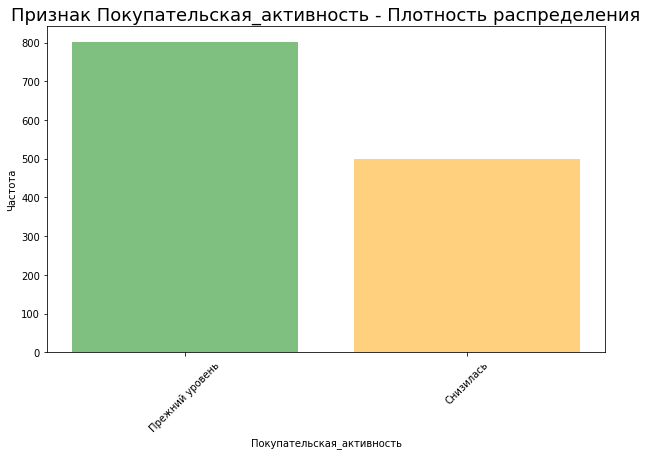

In [24]:
create(df_market_file, 'Покупательская_активность', 'barplot')

На полученной диаграмме видно, что покупательская активность во основном остается на прежнем уровне, что отражено в меньшей высоте правого столбца по сравнению с левым.

**Признак 'Тип_сервиса'**

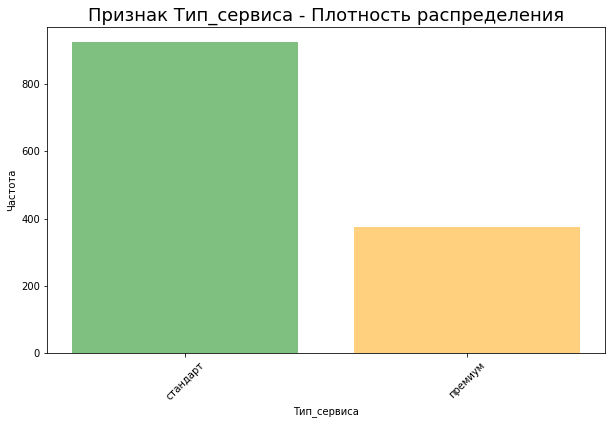

In [25]:
create(df_market_file, 'Тип_сервиса', 'barplot')

Первый столбец с надписью "Стандарт" значительно выше второго столбца с надписью "Премиум", что указывает на более высокую частоту стандартного типа сервиса по сравнению с премиум сервисом.

**Признак 'Разрешить_сообщать'**

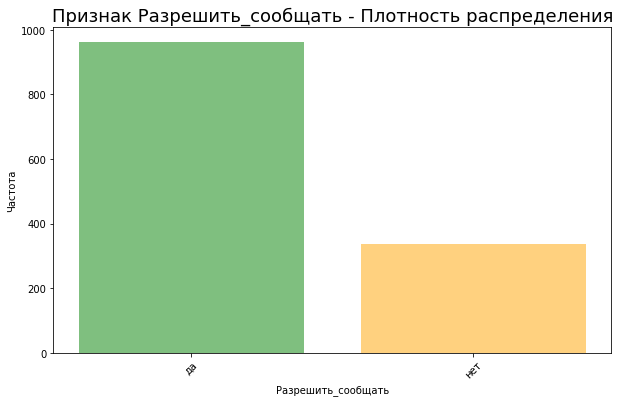

In [26]:
create(df_market_file, 'Разрешить_сообщать', 'barplot')

Большинство данных сгруппированы в левом столбце, который обозначен как "да", что указывает на то, что разрешение на сообщение дано в большем числе случаев. Правый столбец, обозначенный как "нет", ниже по высоте примерно в 3 раза.

**Признак 'Маркет_актив_шесть_мес'**

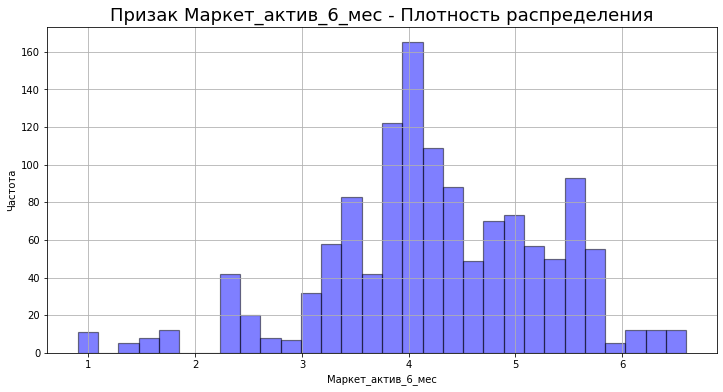

In [27]:
create(df_market_file, 'Маркет_актив_6_мес', 'hist', bins = 30)

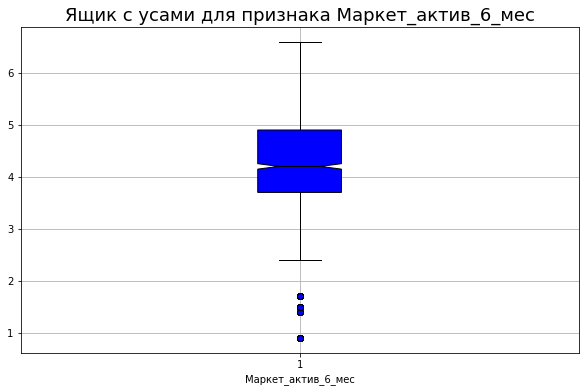

In [28]:
create(df_market_file, 'Маркет_актив_6_мес', 'boxplot')

"Маркет_актив_6_мес" в большинстве случаев имеет среднее значение около 4, с некоторым количеством значений, расположенных дальше от центра распределения, что видно по выбросам на ящике с усами и по более низким столбцам на гистограмме в области более высоких и более низких значений. 

Выбросы находятся на уровне значений от 1 до 2 по шкале признака "Маркет_актив_6_мес".

**Признак 'Маркет_актив_тек_мес'**

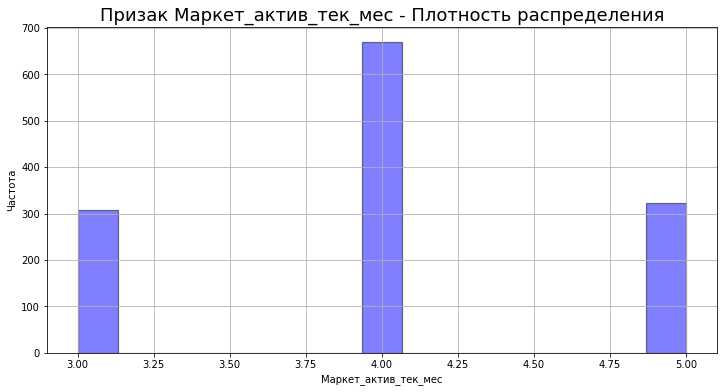

In [29]:
create(df_market_file, 'Маркет_актив_тек_мес', 'hist', bins = 15)

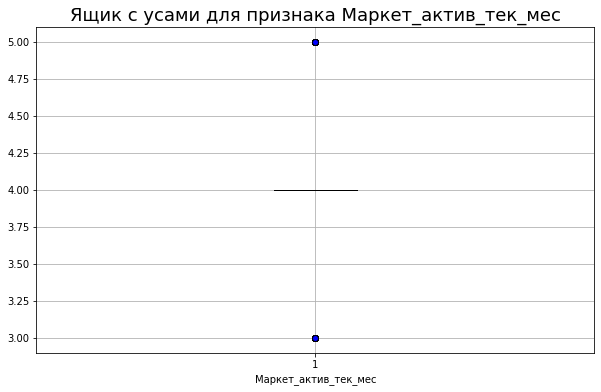

In [30]:
create(df_market_file, 'Маркет_актив_тек_мес', 'boxplot')

Признак "Маркет_актив_тек_мес" чаще всего принимает значение около 4.00, с более редкими значениями вокруг 3.25 и 4.75.

**Признак 'Длительность'**

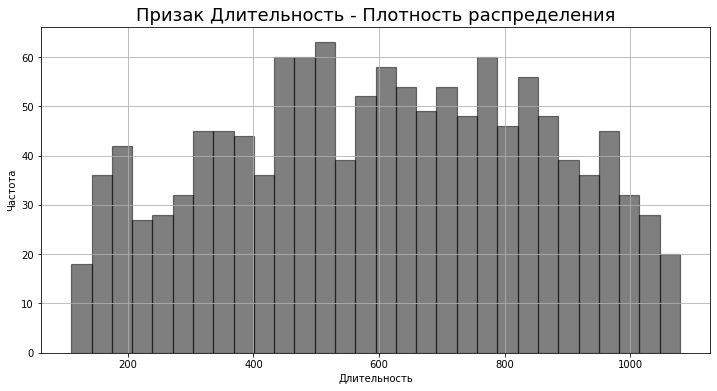

In [31]:
create(df_market_file, 'Длительность', 'hist', bins = 30, color = 'black')

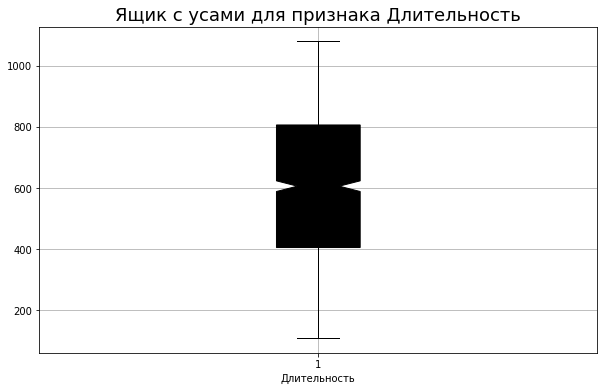

In [32]:
create(df_market_file, 'Длительность', 'boxplot', color = 'black')

Признак "Длительность" имеет несколько часто встречающихся значений, среди которых наибольшую частоту имеют значения в районе 600.

**Признак 'Акционные_покупки'**

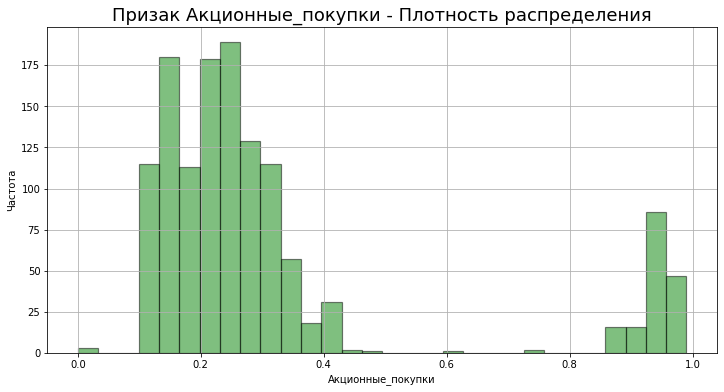

In [33]:
create(df_market_file, 'Акционные_покупки', 'hist', bins = 30, color = 'green')

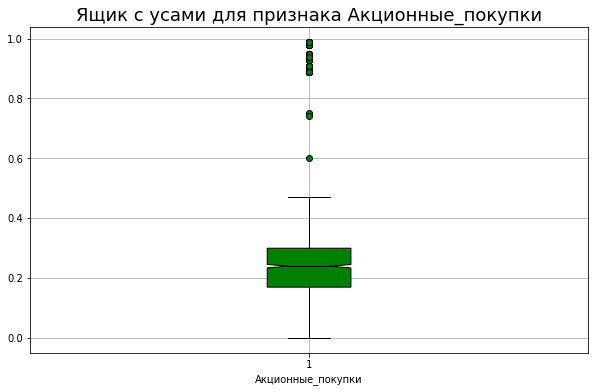

In [34]:
create(df_market_file, 'Акционные_покупки', 'boxplot', color = 'green')

Признак "Акционные_покупки" имеет два основных диапазона значений: один около 0.2-0.4 и второй менее значительный около 0.8-1.0. Медиана и основная масса данных сосредоточена в первом диапазоне, в то время как значения выше 0.6 можно считать относительно редкими и представляют собой выбросы.

**Признак 'Популярная_категория'**

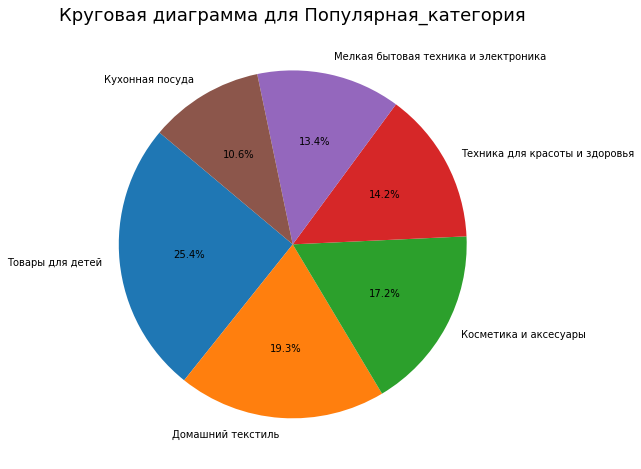

In [35]:
create(df_market_file, 'Популярная_категория', 'pie')

Самый большой сегмент составляют товары для детей, занимающие 25.4%. За ними следуют домашний текстиль с 19.3% и косметика и аксессуары с 17.2%. Техника для красоты и здоровья представлена в размере 14.2%, мелкая бытовая техника и электроника — 13.4%, и кухонная посуда — 10.6%.

**Признак 'Средний_просмотр_категорий_за_визит'**

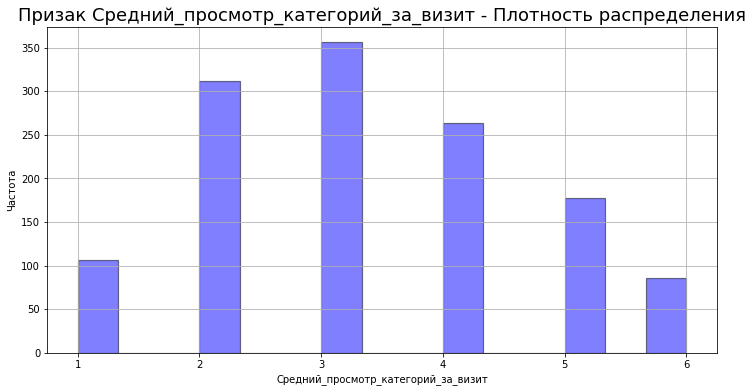

In [36]:
create(df_market_file, 'Средний_просмотр_категорий_за_визит', 'hist', bins = 15)

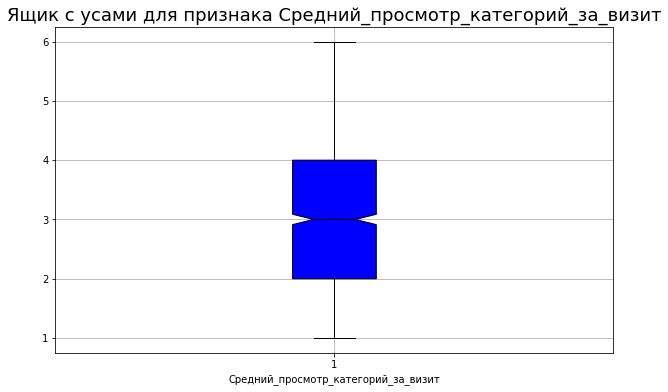

In [37]:
create(df_market_file, 'Средний_просмотр_категорий_за_визит', 'boxplot')

Большинство пользователей в среднем просматривает от двух до трех категорий за визит, при этом некоторые пользователи просматривают значительно больше. Выбросов не наблюдается.

**Признак 'Неоплаченные_продукты_штук_квартал'**

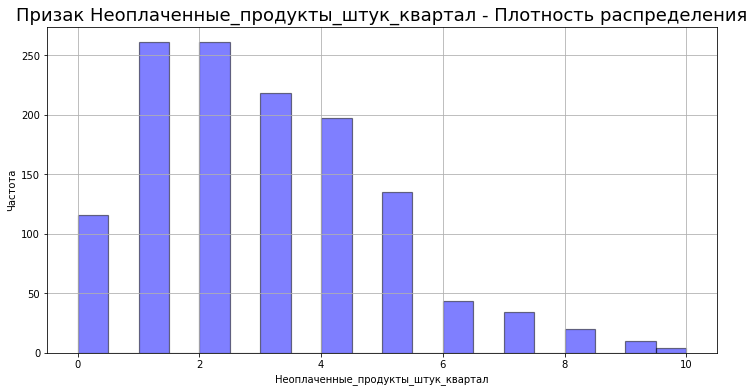

In [38]:
create(df_market_file, 'Неоплаченные_продукты_штук_квартал', 'hist', bins = 20)

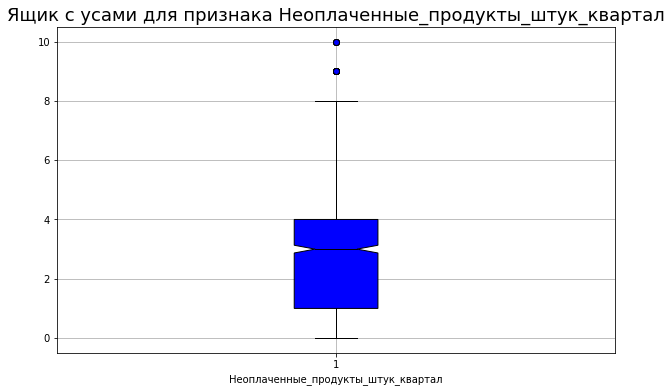

In [39]:
create(df_market_file, 'Неоплаченные_продукты_штук_квартал', 'boxplot')

Большинство случаев включает от одной до трех неоплаченных единиц товара за квартал, с некоторыми исключениями, где количество неоплаченных продуктов значительно выше.

Выбросы находятся на значениях 9, 10.

**Признак 'Ошибка_сервиса'**

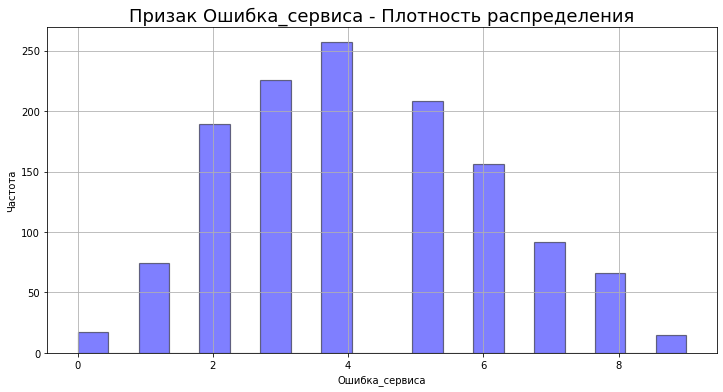

In [40]:
create(df_market_file, 'Ошибка_сервиса', 'hist', bins = 20)

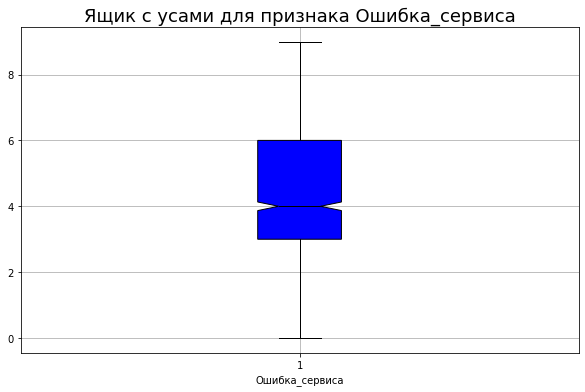

In [41]:
create(df_market_file, 'Ошибка_сервиса', 'boxplot')

В большинстве случаев фиксируется небольшое количество ошибок сервиса, и лишь в отдельных ситуациях число ошибок значительно выше. Выбросов не наблюдается.

**Признак 'Страниц_за_визит'**

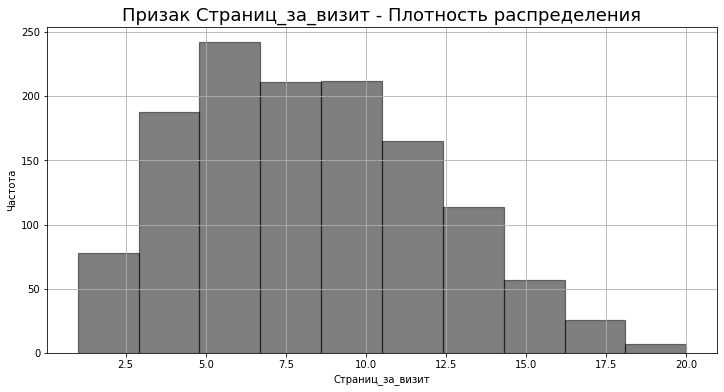

In [42]:
create(df_market_file, 'Страниц_за_визит', 'hist', bins = 10, color = 'black')

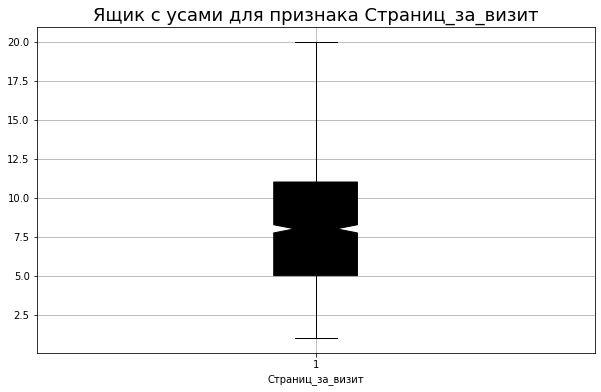

In [43]:
create(df_market_file, 'Страниц_за_визит', 'boxplot', color = 'black')

Большинство пользователей просматривают от 5 до 10 страниц во время одного визита на сайт, с небольшим числом визитов, включающих просмотр значительно большего количества страниц. Выбросы отсутствуют.

#### Анализ датасета df_market_money с использованием метода describe

In [44]:
display(df_market_money.describe().T)

,count,mean,std,min,25%,50%,75%,max
id,3900.0,215997.500000,375.325686,215348.0,215672.75,215997.5,216322.25,216647.0
Выручка,3900.0,5025.696051,1777.704104,0.0,4590.15,4957.5,5363.00,106862.2


Признак 'Выручка' имеет значительный разброс и потенциальные выбросы, с максимальным значением значительно превышающим 75-й перцентиль.

#### Анализ датасета df_market_money с использованием диаграмм

**Признак 'Период'**

Больше всего выручки было зафиксировано в 'препредыдущий месяц' (34.8%). 

Далее идет 'предыдущий месяц' (33.6%). 

Меньше всего прибыли получено в 'текущий месяц' (31.5%).

**Признак 'Выручка'**

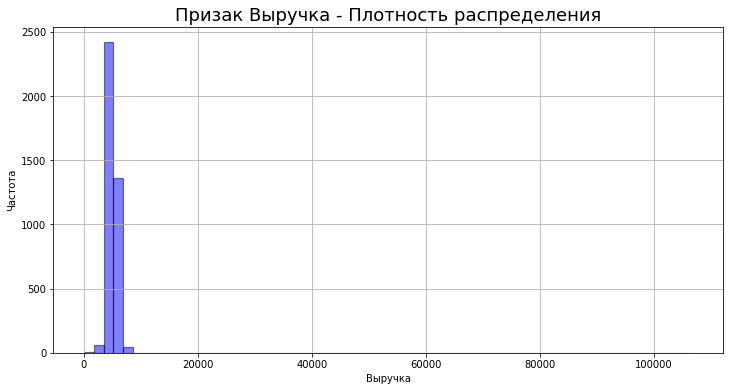

In [45]:
create(df_market_money, 'Выручка', 'hist', bins = 62)

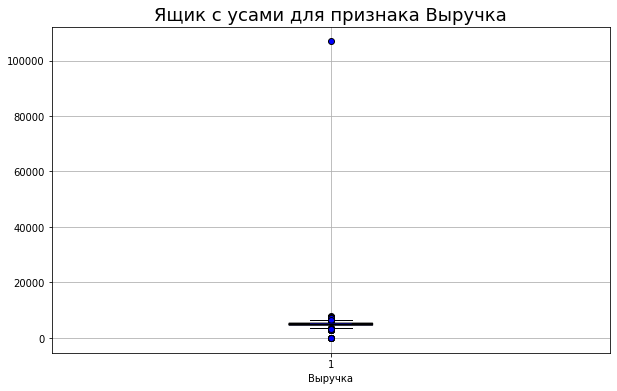

In [46]:
create(df_market_money, 'Выручка', 'boxplot')

In [47]:
# Рассчитаем межквартильный размах (IQR) и границы выбросов 
Q1 = 4590.15
Q3 = 5363.00
IQR = Q3 - Q1

# Границы выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f'Нижняя граница: {lower_bound}\nВерхняя граница: {upper_bound}')

Нижняя граница: 3430.874999999999
Верхняя граница: 6522.275000000001


Большинство значений признака "Выручка" сосредоточены около нуля, что указывает на большое количество низких или нулевых значений выручки. На ящике с усами наблюдается, что медиана признака "Выручка" также расположена близко к нулю, при этом имеются выбросы с аномально высокими значениями, достигающими 100000, что может свидетельствовать о необычно больших транзакциях или аномалиях в данных.

#### Анализ датасета df_market_time с использованием метода describe

In [48]:
display(df_market_time.describe().T)

,count,mean,std,min,25%,50%,75%,max
id,2600.0,215997.500000,375.349754,215348.0,215672.75,215997.5,216322.25,216647.0
минут,2600.0,13.336154,4.080198,4.0,10.00,13.0,16.00,23.0


Переменная 'минут' имеет умеренный разброс значений, с максимальным значением немногим выше 75-го перцентиля, что говорит о более равномерном и ограниченном распределении продолжительности сессий или затраченного времени.

#### Анализ датасета df_market_time с использованием диаграмм

**Признак 'Период'**

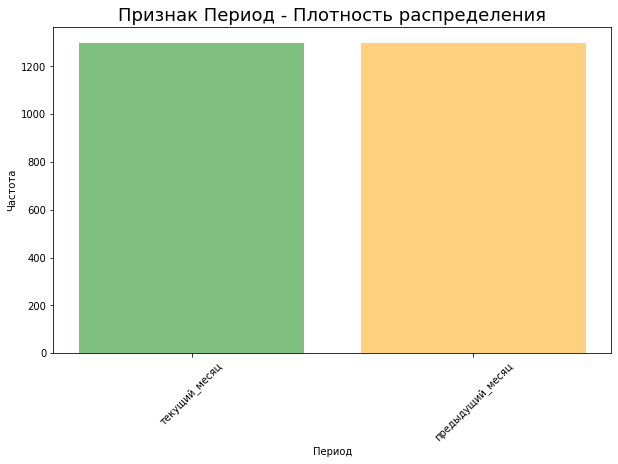

In [49]:
create(df_market_time, 'Период', 'barplot')

Левый столбец, относящийся к "Первый месяц", идентичен правому столбцу "Текущий месяц".

**Признак 'минут'**

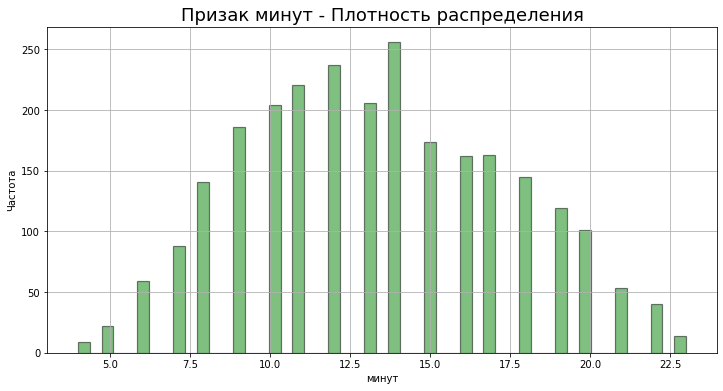

In [50]:
create(df_market_time, 'минут', 'hist', bins = 51, color = 'green')

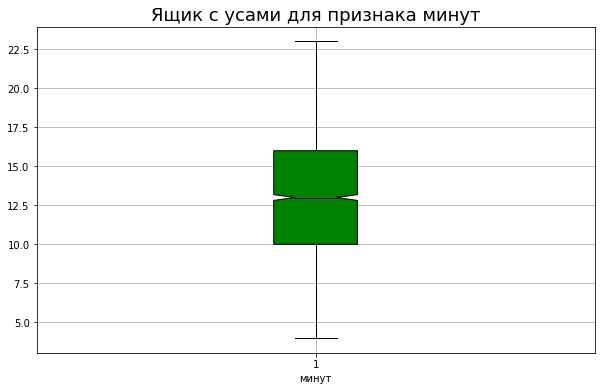

In [51]:
create(df_market_time, 'минут', 'boxplot', color = 'green')

На гистограмме видно несколько пиков, наиболее выраженных около значений 10 и 15.

На ящике с усами видно, что медиана находится около значения 13, с интерквартильным размахом от 10 до 16, что указывает на среднюю продолжительность сессий в данных. Наличие выбросов не наблюдается, так как все точки находятся в пределах усов.

#### Анализ датасета df_money с использованием метода describe

In [52]:
display(df_money.describe().T)

,count,mean,std,min,25%,50%,75%,max
id,1300.0,215997.500000,375.421985,215348.00,215672.75,215997.500,216322.25,216647.00
Прибыль,1300.0,3.996631,1.013722,0.86,3.30,4.045,4.67,7.43


'Прибыль' имеет среднее значение около 4 с относительно небольшим стандартным отклонением, что говорит о том, что большинство значений прибыли сосредоточены вокруг среднего, с минимальным значением ниже 1 и максимальным чуть выше 7, не показывая явных признаков аномальных значений или выбросов.

#### Анализ датасета df_money с использованием диаграмм

**Признак 'Прибыль'**

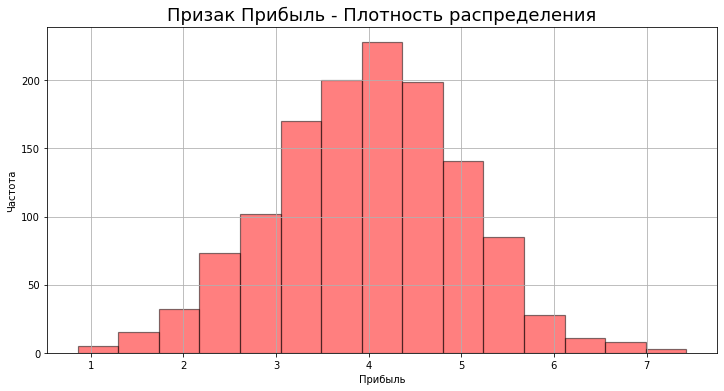

In [53]:
create(df_money, 'Прибыль', 'hist', bins = 15, color = 'red')

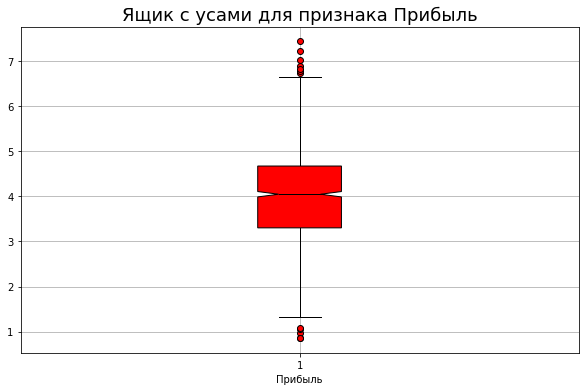

In [54]:
create(df_money, 'Прибыль', 'boxplot', color = 'red')

In [55]:
# Рассчитаем межквартильный размах (IQR) и границы выбросов 
Q1 = 3.3
Q3 = 4.67
IQR = Q3 - Q1

# Границы выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f'Нижняя граница: {lower_bound}\nВерхняя граница: {upper_bound}')

Нижняя граница: 1.2449999999999997
Верхняя граница: 6.725


На диаграмме виден пик около значения 4. 

На ящике с усами видно, что медиана находится в значении 4, выбросы расположены в значениях меньше 1.25 и в значениях больших 6.725

#### Вывод по анализу данных методом describe и диаграммами 
**1. Датасет df_money:**
* Признак 'Прибыль': выбросы расположены в значениях меньше 1.25 и в значениях больших 6.725

#### Датасет df_market_money

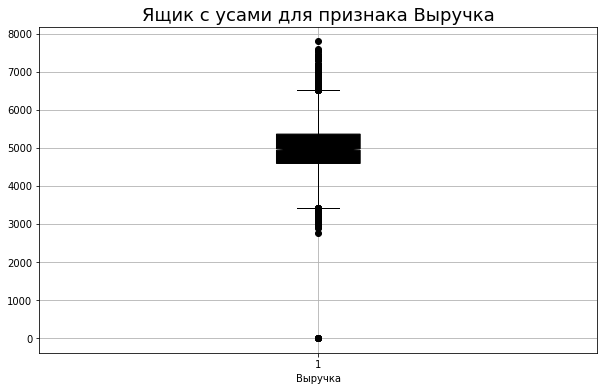

In [56]:
df_market_money = df_market_money[df_market_money['Выручка'] < 10000]

create(df_market_money, 'Выручка', 'boxplot', color = 'black')

#### Датасет df_money

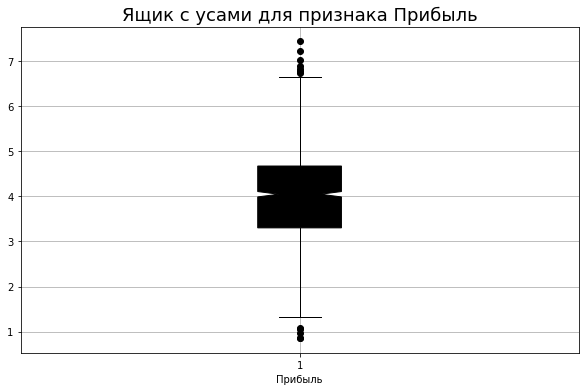

In [57]:
df_money = df_money[(df_money['Прибыль'] > 1) & (df_money['Прибыль']) < 7]

create(df_money, 'Прибыль', 'boxplot', color = 'black')

**Выбросы удалены**

### Отбор клиентов с покупательской активностью не менее трёх месяцев

Сделаем сводную таблицу по выручке за последние 3 месяца по датасету df_market_money (по признаку 'Период')

In [58]:
df_pivot_money = df_market_money.pivot(index='id', columns='Период', values='Выручка')
display(df_pivot_money.head())

Период,предыдущий_месяц,препредыдущий_месяц,текущий_месяц
id,,,
215348,0.0,0.0,3293.1
215349,5216.0,4472.0,4971.6
215350,5457.5,4826.0,5058.4
215351,6158.0,4793.0,6610.4
215352,5807.5,4594.0,5872.5


In [59]:
df_pivot_money = df_pivot_money[(df_pivot_money['предыдущий_месяц'] >0) & (df_pivot_money['препредыдущий_месяц']>0) & (df_pivot_money['текущий_месяц'] > 0)]

In [60]:
# код ревьюера
display(df_pivot_money.head())

Период,предыдущий_месяц,препредыдущий_месяц,текущий_месяц
id,,,
215349,5216.0,4472.0,4971.6
215350,5457.5,4826.0,5058.4
215351,6158.0,4793.0,6610.4
215352,5807.5,4594.0,5872.5
215353,4738.5,5124.0,5388.5


**Переименуем столбцы и объединим таблицы (сводную таблицу по выручке за последние 3 месяца и датасет df_market_file).**

In [61]:
df_pivot_money = df_pivot_money.rename(columns={
    'текущий_месяц': 'Выручка_за_текущий_месяц',
    'предыдущий_месяц': 'Выручка_за_предыдущий_месяц',
    'препредыдущий_месяц': 'Выручка_за_препредыдущий_месяц'
})

merged_df = df_market_file.merge(df_pivot_money, on='id', how='left')
display(merged_df.head())

,id,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_за_предыдущий_месяц,Выручка_за_препредыдущий_месяц,Выручка_за_текущий_месяц
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,NaN,NaN,NaN
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5


### Промежуточный вывод по исследовательскому анализу данных
**На данном этапе были проанализированы все 4 датасета, а также их признаки:**
1. Были удалены выбросы в датасетах:
    * df_market_file:
        * 'Маркет_актив_6_мес' - значения меньше 2
        * 'Маркет_актив_тек_мес' - значения меньше 3.25 и больше 4.75
        * 'Акционные_покупки' - значения больше 0.6
        * 'Неоплаченные_продукты_штук_квартал' - значения больше 9
    * df_market_money:
        * 'Выручка' - значения меньше 3430 и больше 6522
    * df_money:
        * 'Прибыль' - значения меньше 1.25 и больше 6.725

В датасете df_market_time выбросов не обнаружено.

2. Были отобраны клиенты с покупательской активностью не менее трёх месяцев (сводная таблица merged_df)

## Шаг 4. Объединение таблиц

Создадим сводную таблицу по выручке за 2 месяца ('предыдущий_месяц' и 'текущий_месяц') по датасету df_market_time.

In [64]:
df_pivot_time = df_market_time.pivot(index='id', columns='Период', values='минут')

display(df_pivot_time.head())

Период,предыдущий_месяц,текущий_месяц
id,,
215348,13,14
215349,12,10
215350,8,13
215351,11,13
215352,8,11


### Переименуем столбцы и объединим датасеты (сводная таблица по выручке за 2 месяца и уже объединенный датасет из исследовательского анализа)

In [65]:
df_pivot_time = df_pivot_time.rename(columns={
    'текущий_месяц': 'Минут_за_текущий_месяц',
    'предыдущий_месяц': 'Минут_за_предыдущий_месяц'
})

merged_df = merged_df.merge(df_pivot_time, on='id', how='left')
display(merged_df.head())

,id,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_за_предыдущий_месяц,Выручка_за_препредыдущий_месяц,Выручка_за_текущий_месяц,Минут_за_предыдущий_месяц,Минут_за_текущий_месяц
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,NaN,NaN,NaN,13,14
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11


### Проверим общую информацию об объединенному датасете, наличие дубликатов и пропусков

In [66]:
print(merged_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 0 to 1299
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская_активность            1300 non-null   object 
 2   Тип_сервиса                          1300 non-null   object 
 3   Разрешить_сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [67]:
print('Количество дубликатов в объединенном датасете:', merged_df.duplicated().sum())

Количество дубликатов в объединенном датасете: 0


In [68]:
print('Количество пропусков в объединенном датасете:', '\n', merged_df.isna().sum())

Количество пропусков в объединенном датасете: 
 id                                     0
Покупательская_активность              0
Тип_сервиса                            0
Разрешить_сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
Выручка_за_предыдущий_месяц            4
Выручка_за_препредыдущий_месяц         4
Выручка_за_текущий_месяц               4
Минут_за_предыдущий_месяц              0
Минут_за_текущий_месяц                 0
dtype: int64


**Удалим пропуски**

In [69]:
merged_df = merged_df.dropna()
merged_df = merged_df.reset_index(drop=True)
print('Количество пропусков в объединенном датасете после удаления:', '\n', merged_df.isna().sum())

Количество пропусков в объединенном датасете после удаления: 
 id                                     0
Покупательская_активность              0
Тип_сервиса                            0
Разрешить_сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
Выручка_за_предыдущий_месяц            0
Выручка_за_препредыдущий_месяц         0
Выручка_за_текущий_месяц               0
Минут_за_предыдущий_месяц              0
Минут_за_текущий_месяц                 0
dtype: int64


In [70]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296 entries, 0 to 1295
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1296 non-null   int64  
 1   Покупательская_активность            1296 non-null   object 
 2   Тип_сервиса                          1296 non-null   object 
 3   Разрешить_сообщать                   1296 non-null   object 
 4   Маркет_актив_6_мес                   1296 non-null   float64
 5   Маркет_актив_тек_мес                 1296 non-null   int64  
 6   Длительность                         1296 non-null   int64  
 7   Акционные_покупки                    1296 non-null   float64
 8   Популярная_категория                 1296 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1296 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 11  Ошибка_сервиса                

### Промежуточный вывод по объединению таблиц
Были объединены: созданный датасет из исследовательского анализа с отобранными клиентами  с покупательской активностью не менее 3 месяцев (датасеты df_market_file и df_market_money) и сводная таблица по датасету df_market_time.

Созданный датасет был проверен на наличие дубликатов и пропусков:
* Дубликатов не обнаружено;
* Пропуски обнаружены и удалены  

## Шаг 5. Корреляционный анализ

### Тест Шапиро-Уилка 

In [72]:
num_col, cat_col = cat_num_col(merged_df)
for col_name in num_col:
    test_Shapiro_Wilk(merged_df, col_name)
    print()

Результат теста Шапиро-Уилка для столбца Маркет_актив_6_мес:
Статистика теста: 0.9780305624008179
p-значение: 3.778057781986949e-13
Распределение данных не является нормальным.

Результат теста Шапиро-Уилка для столбца Маркет_актив_тек_мес:
Статистика теста: 0.8058887720108032
p-значение: 8.104834990532471e-37
Распределение данных не является нормальным.

Результат теста Шапиро-Уилка для столбца Длительность:
Статистика теста: 0.9726013541221619
p-значение: 5.744778195087164e-15
Распределение данных не является нормальным.

Результат теста Шапиро-Уилка для столбца Акционные_покупки:
Статистика теста: 0.6577359437942505
p-значение: 4.203895392974451e-45
Распределение данных не является нормальным.

Результат теста Шапиро-Уилка для столбца Средний_просмотр_категорий_за_визит:
Статистика теста: 0.9305698871612549
p-значение: 4.67610633319053e-24
Распределение данных не является нормальным.

Результат теста Шапиро-Уилка для столбца Неоплаченные_продукты_штук_квартал:
Статистика теста: 0.93

**Тест Шапиро-Уилка показал, что распределение не является нормальным.**

Так как коэффициент корелляции Пирсона, предполагает нормальность распределения, будем использовать корелляцию Спирмена. Этот метод корелляции не требует нормальности распределения. 

### Корреляционный анализ признаков в количественной шкале в итоговой таблице для моделирования

**Проведём корелляционный анализ для двух классов:**
1. Покупательская активность осталась на прежнем уровне 
2. Покупательская активность снизилась

**Покупательская активность на прежнем уровне**

In [73]:
merged_df_previous = merged_df[merged_df['Покупательская_активность'] == 'Прежний уровень']

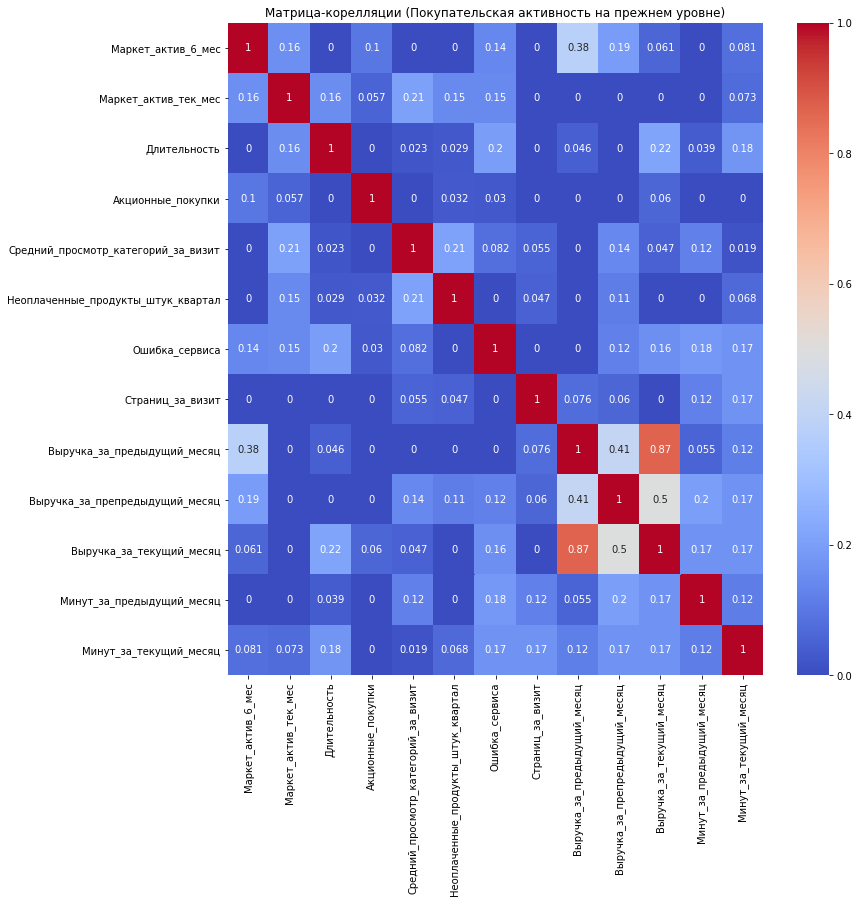

In [74]:
corr_matrix = merged_df_previous[num_col].phik_matrix(num_col)
plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Матрица-корелляции (Покупательская активность на прежнем уровне)')
plt.show()

**Покупательская активность снизилась**

In [75]:
merged_df_get_lower = merged_df[merged_df['Покупательская_активность'] == 'Снизилась']

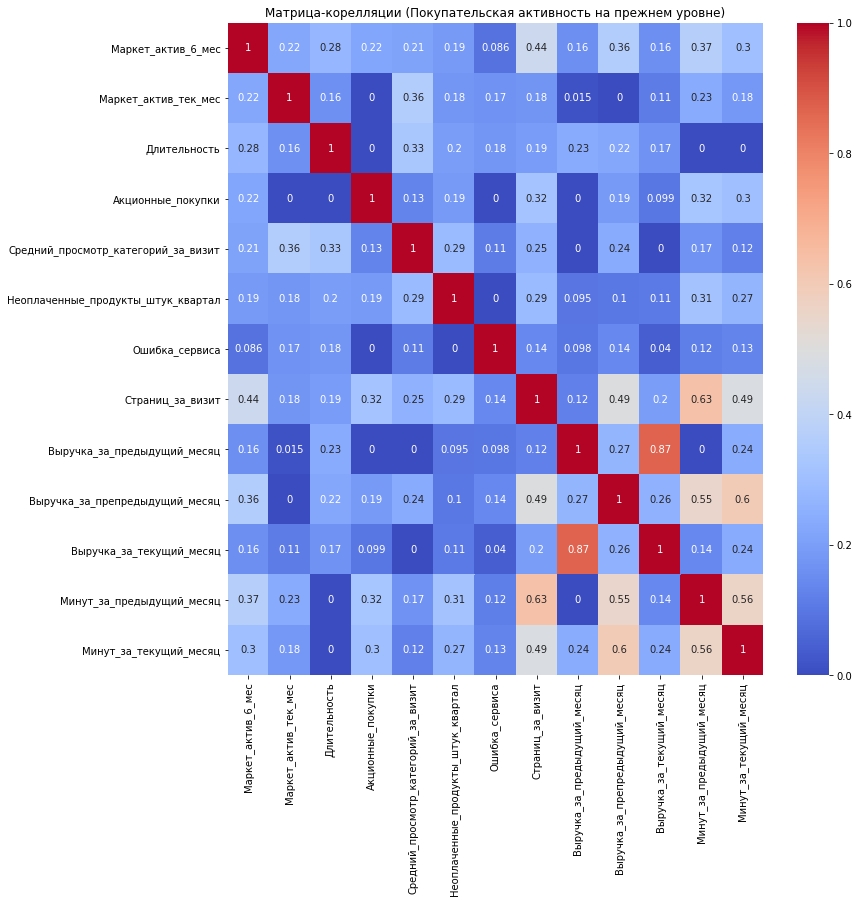

In [76]:
corr_matrix = merged_df_get_lower[num_col].phik_matrix(num_col)
plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Матрица-корелляции (Покупательская активность на прежнем уровне)')
plt.show()

### Промежуточный вывод по корелляционному анализу

**Матрица-корелляции (Покупательская активность на прежнем уровне)**
1. Сильная корелляция:
    * Наблюдается между признаками 'Выручка_за_предыдущий_месяц' и 'Выручка_за_текущий_месяц': **79%**
2. Средняя корелляция:
    * Наблюдается между признаками 'Выручка_за_препредыдущий_месяц' и 'Выручка_за_предыдущий_месяц': **48%**
    * Наблюдается между признаками 'Выручка_за_препредыдущий_месяц' и 'Выручка_за_текущий_месяц': **61%**
3. Слабая или отрицательная корелляция:
    * Наблюдается между всеми остальными признаками 

**Матрица-корелляции (Покупательская активность на прежнем уровне)**
1. Сильная корелляция:
    * Наблюдается между признаками 'Выручка_за_текущий_месяц' и 'Выручка_за_предыдущий_месяц': **80%**
2. Средняя корелляция:
    * Наблюдается между признаками 'Минут_за_текущий_месяц' и 'Минут_за_предыдущий_месяц' : **55%**
    * Наблюдается между признаками 'Страниц_за_визит' и 'Минут_за_предыдущий_месяц' : **63%**
    * Наблюдается между признаками 'Выручка_за_препредыдущий_месяц' и 'Минут_за_предыдущий_месяц': **55%**
    * Наблюдается между признаками 'Минут_за_текущий_месяц' и 'Выручка_за_препредыдущий_месяц' : **57%**
    * Наблюдается между признаками 'Выручка_за_препредыдущий_месяц' и 'Страниц_за_визит': **49%**
3. Слабая или отрицательная корелляция:
    * Наблюдается между всеми остальными признаками
    
**Мультиколлинеарности не обнаружено**

## Шаг 6. Использование пайплайнов
План разработки пайплайна машинного обучения:

1. Подготовка данных:
    * Разделение исходного набора данных на обучающую и тестовую выборки, определение размера тестовой выборки в 25% от общего объема данных.
    * Применение стратификации при разделении для сохранения пропорционального распределения классов, особенно если целевая переменная имеет несбалансированное распределение.
2. Предварительная обработка данных:
    * Преобразование категориальных признаков с помощью OneHotEncoder и порядковых признаков с помощью OrdinalEncoder.
    * Заполнение пропущенных значений при помощи SimpleImputer для числовых и категориальных переменных.
3. Конструирование признаков:
    * Создание трансформера данных, который интегрирует все необходимые шаги преобразования, включая нормализацию или стандартизацию числовых данных (например, с помощью StandardScaler).
4. Выбор модели и разработка пайплайна:
    * Создание базового пайплайна, который объединяет предобработку данных и модель обучения, например DecisionTreeClassifier.
    * Расширение пайплайна до ансамблевых методов, таких как RandomForestClassifier, LogisticRegression, SVC и KNeighborsClassifier.
5. Настройка гиперпараметров:
    * Определение гиперпараметров для настройки моделей (DecisionTreeClassifier, RandomForestClassifier и др.).
    * Применение RandomizedSearchCV или GridSearchCV для поиска оптимальных гиперпараметров с целью максимизации выбранной метрики качества (roc_auc).
6. Валидация модели:
    * Обучение моделей с лучшими найденными параметрами на обучающей выборке.
    * Валидация модели на тестовой выборке для оценки способности модели обобщать результаты на новых данных.
7. Оценка производительности:
    * Анализ метрик производительности лучшей модели (точность, полнота, F1-мера, ROC-AUC) на обучающей и тестовой выборках.
    * Визуализация результатов через ROC-кривую для наглядности производительности модели.

### Подготовка данных и разработка пайплайна

In [77]:
merged_df['Покупательская_активность'] = merged_df['Покупательская_активность'].apply(lambda x: 0 if x == 'Снизилась' else (1 if x == 'Прежний уровень' else x))


In [78]:

X_train, X_test, y_train, y_test = train_test_split(
    merged_df.drop(['Покупательская_активность', 'id'], axis=1),
    merged_df['Покупательская_активность'],
    random_state=RANDOM_STATE,
    test_size=TEST_SIZE,
    stratify = merged_df['Покупательская_активность']
)
matrix =   merged_df.drop(['Покупательская_активность', 'id'], axis=1)
ohe_col = ['Популярная_категория']
ord_col = ['Тип_сервиса', 'Разрешить_сообщать']

In [79]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='error', sparse=False)
        )
    ]
)

ord_pipe = Pipeline([
    (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
    (
            'ord',  
            OrdinalEncoder(
                categories=[
                    ['стандарт', 'премиум'], 
                    ['нет', 'да'],
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
    ), 
    (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
]
)

data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_col),
        ('ord', ord_pipe, ord_col),
        ('num', StandardScaler(), num_col)
    ], 
    remainder='passthrough'
) 

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

### Настройка гиперпараметров

In [80]:

param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': [3, 4, 5],
        'models__min_samples_split': range(1, 10),
        'models__min_samples_leaf': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }, 
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1')],
        'models__C': [0.1, 1, 10], 
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }, 
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__C': [0.1, 1, 10],
        'models__kernel': ['rbf', 'sigmoid', 'linear', 'poly'], 
        'models__gamma': [0.1, 1, 10],
        'models__degree': [2, 3, 4],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': [3, 5, 7],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    }
]

random_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE)

random_search.fit(X_train, y_train)
print('Лучшая модель и ее параметры:\n\n', random_search.best_estimator_)
print('Метрика лучшей модели на тренировочной выборке:', random_search.best_score_)

pred = random_search.predict(X_test)

probabilities = random_search.predict_proba(X_test)
probabilities_one = probabilities[:, 1]   

print('Площадь ROC-кривой:', roc_auc_score(y_test, probabilities_one))

warnings.filterwarnings('ignore')



Лучшая модель и ее параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['Популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
               

### Промежуточный вывод по пайплайну
**Оценка модели:**

Лучшей моделью является SVC с гиперпараметрами:
* C=0.1;
* degree=2;
* gamma=10;
* kernel = 'linear';
* probability = True;
* random_state = 42

**Оценка метрик:**
* Метрика качества модели на тренировочной выборке высока и составляет  0.9073685875958603;
* Метрика ROC-AUC на тестовой выборке также высока — 0.888266129032258

## Шаг 7. Анализ важности признаков

### Построение shap таблицы для оценки важности

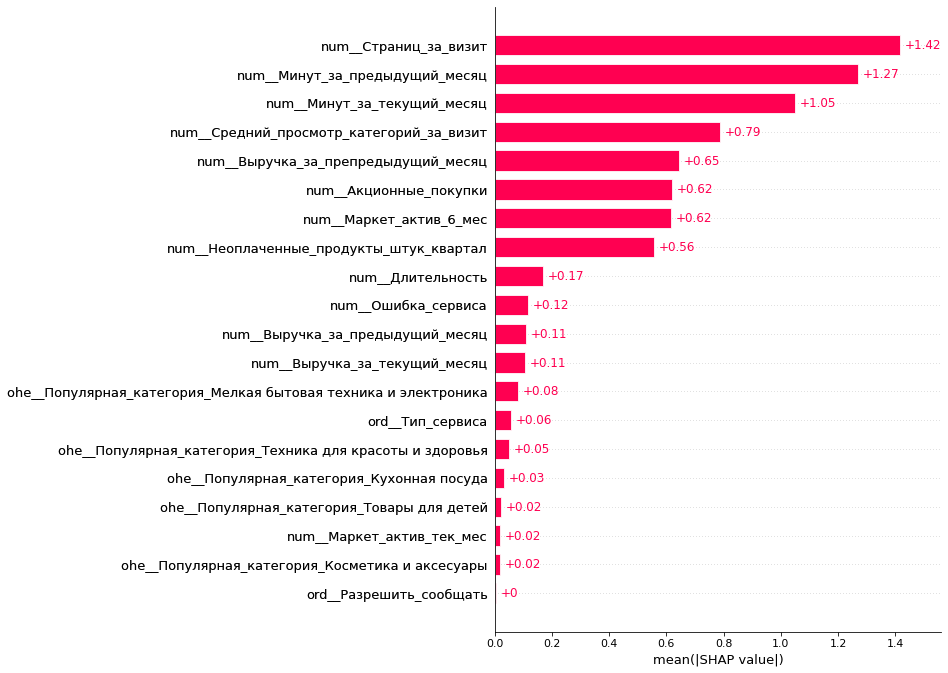

None

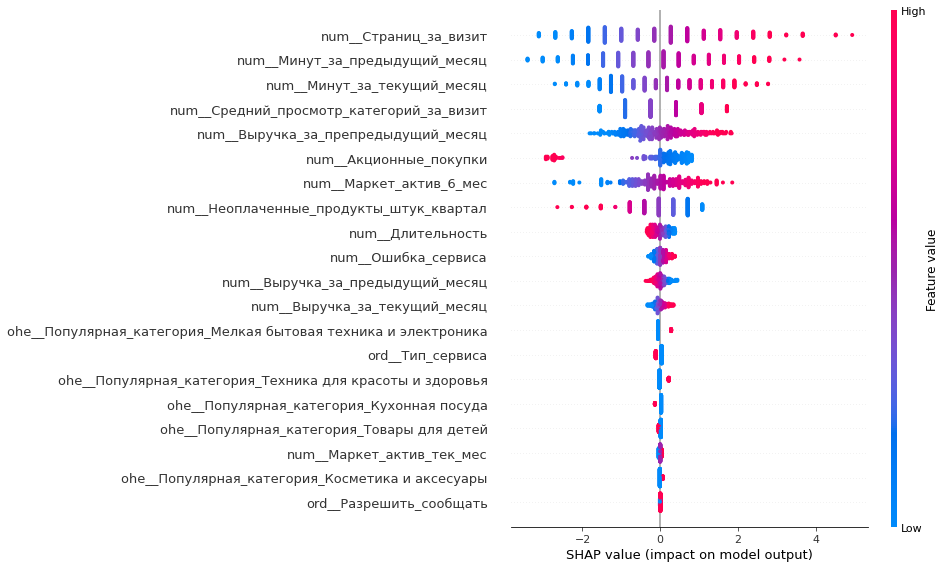

In [82]:
X_train_2 = pipe_final.named_steps['preprocessor'].fit_transform(X_train)

explainer = shap.Explainer(random_search.best_estimator_.named_steps['models'], X_train_2)

X_test_2 = pipe_final.named_steps['preprocessor'].transform(X_test)

feature_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()

X_test_2 = pd.DataFrame(X_test_2, columns=feature_names)

shap_values = explainer(X_test_2)

display(shap.plots.bar(shap_values, max_display=22))
shap.plots.beeswarm(shap_values, max_display=22) 

### Промежуточный вывод по анализу важности признаков

На основе этого графика можно сделать следующие выводы:
1. **Наиболее значимые признаки:**

Признаки в верхней части графика, такие как num_Страниц_за_визит, num_Минут_за_предыдущий_месяц и num_Акционные_покупки, имеют более широкое распределение точек по горизонтали, что указывает на их сильное влияние на целевой признак. Широкое распределение также свидетельствует о том, что эти признаки имеют различное влияние в зависимости от их значений.

2. **Малозначимые признаки:**

Признаки в нижней части графика, такие как ord_Тип_сервиса, num_Выручка_текущий_месяц и ohe_Популярная_категория_Товары для детей, показывают меньшее влияние на целевой признак, поскольку их точки сгруппированы ближе к нулевой линии, и распределение менее разнообразно.

3. **Использование наблюдений для моделирования и принятия бизнес-решений:**
* При оптимизации модели можно сосредоточиться на наиболее значимых признаках, возможно, увеличив их вес или проведя дополнительный анализ для улучшения их качества или представления.
* Признаки с меньшим влиянием могут быть кандидатами на удаление из модели, чтобы упростить модель и сократить время обучения, особенно если датасет очень большой.
* В бизнес-контексте признаки с наибольшим влиянием могут указывать на области, которые требуют особого внимания. Например, если num_Страниц_за_визит является важным признаком, это может означать, что улучшение пользовательского опыта на сайте может существенно повлиять на целевые бизнес-показатели.

## Шаг 8. Сегментация покупателей

### Используем результаты моделирования и данные о прибыльности покупателей.

In [85]:
filtered_df_money = df_money[df_money['id'].isin(merged_df['id'])]

class_probabilities = random_search.predict_proba(matrix)

df_segmentation = filtered_df_money.copy()

df_segmentation['вероятность_снижения'] = class_probabilities[:, 0]

display(df_segmentation.head())

,id,Прибыль,вероятность_снижения
1,215349,4.16,0.934030
2,215350,3.13,0.420315
3,215351,4.87,0.855612
4,215352,4.21,0.977859
5,215353,3.95,0.640320


### Оценка зависимости между признаками: 'Прибыль' и 'вероятность_снижения'

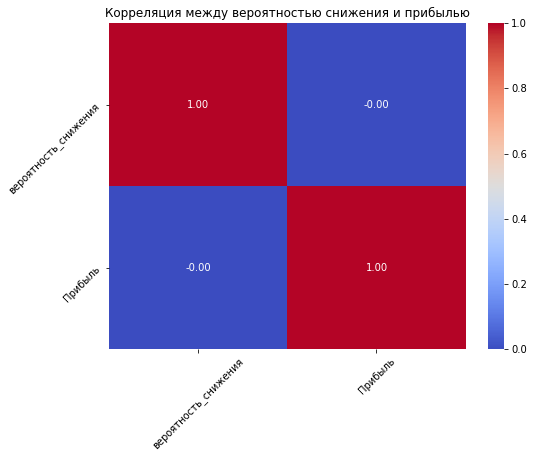

In [86]:
correlation_matrix = df_segmentation[['вероятность_снижения', 'Прибыль']].corr(method='spearman')

plt.figure(figsize=(8, 6))  
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')

plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.title('Корреляция между вероятностью снижения и прибылью');

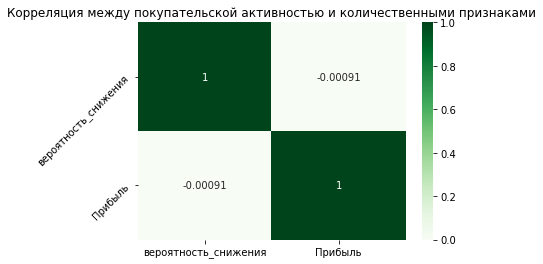

In [87]:
correlation_matrix = df_segmentation[['вероятность_снижения', 'Прибыль']].corr(method='spearman')
sns.heatmap(correlation_matrix, annot=True, cmap='Greens')
plt.yticks(rotation=45)
plt.title(f'Корреляция между покупательской активностью и количественными признаками')
plt.show()

На основе полученных диаграмм можно сделать следующие выводы:
1. *Тепловая карта корреляции:*
    * Корреляция между вероятностью снижения и Прибылью очень слабая, значение коэффициента корреляции Спирмена равно 0.03.
2. *Диаграмма рассеяния:*
    * Точки на диаграмме рассеяния распределены равномерно по всей плоскости графика, не показывая явных трендов или закономерностей.
    * Отсутствие какой-либо очевидной тенденции на диаграмме рассеяния подтверждает выводы, сделанные на основе тепловой карты корреляции — между вероятностью снижения и Прибылью нет сильной связи.


### Выбор покупателей, у которых высокая прибыль и высокая вероятность снижения покупательской активности

In [88]:
df_segmentation.describe()

,id,Прибыль,вероятность_снижения
count,1296.000000,1296.000000,1296.000000
mean,215999.464506,3.997701,0.378339
std,374.327860,1.011198,0.368431
min,215349.000000,0.860000,0.000013
25%,215675.750000,3.300000,0.064931
50%,215999.500000,4.045000,0.195159
75%,216323.250000,4.670000,0.805782
max,216647.000000,7.430000,0.998371


In [89]:
df_segmentation['категория'] = 'остальные' 
condition = (df_segmentation['Прибыль'] > 4) & (df_segmentation['вероятность_снижения'] > 0.75)
df_segmentation.loc[condition, 'категория'] = 'категория 1'
df_segmentation = df_segmentation[df_segmentation['категория'] != 'остальные']
df_reserch = df_segmentation.merge(merged_df, on='id', how='inner')
df_reserch.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 194 entries, 0 to 193
Data columns (total 21 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   194 non-null    int64  
 1   Прибыль                              194 non-null    float64
 2   вероятность_снижения                 194 non-null    float64
 3   категория                            194 non-null    object 
 4   Покупательская_активность            194 non-null    int64  
 5   Тип_сервиса                          194 non-null    object 
 6   Разрешить_сообщать                   194 non-null    object 
 7   Маркет_актив_6_мес                   194 non-null    float64
 8   Маркет_актив_тек_мес                 194 non-null    int64  
 9   Длительность                         194 non-null    int64  
 10  Акционные_покупки                    194 non-null    float64
 11  Популярная_категория            

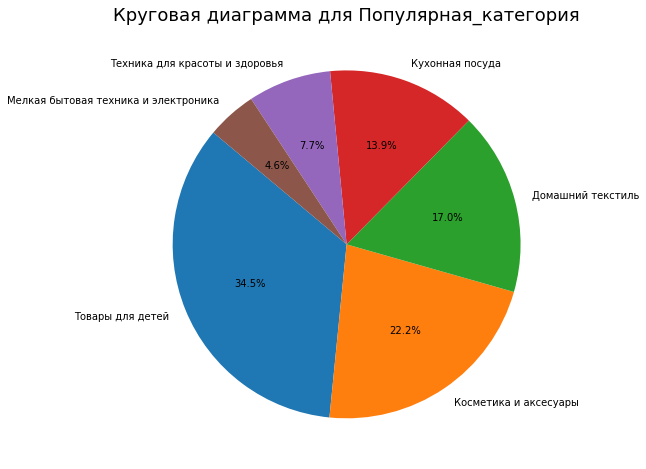

In [90]:
create(df_reserch, 'Популярная_категория', 'pie')

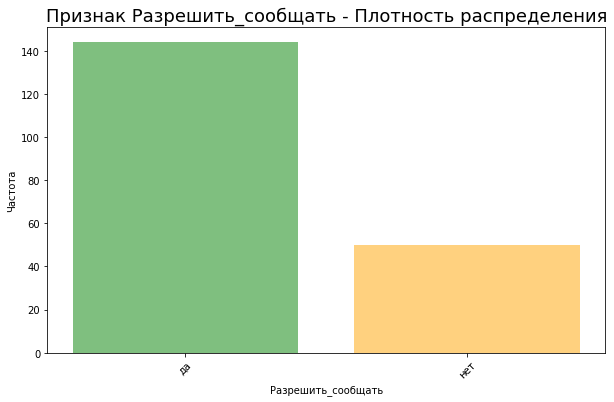

In [91]:
create(df_reserch, 'Разрешить_сообщать', 'barplot')

In [92]:
num_research = ['Страниц_за_визит', 'Минут_за_предыдущий_месяц', 'Минут_за_текущий_месяц',
                'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал']


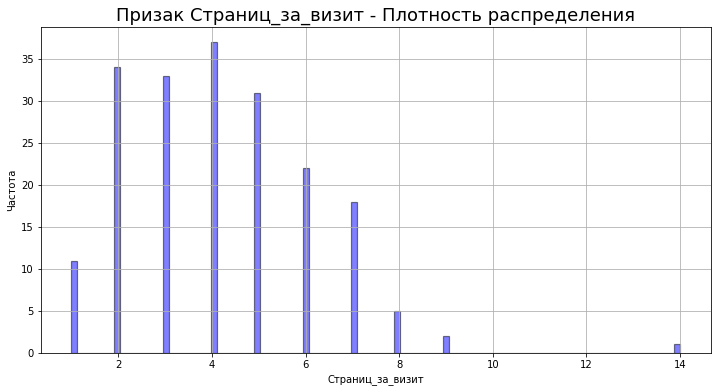

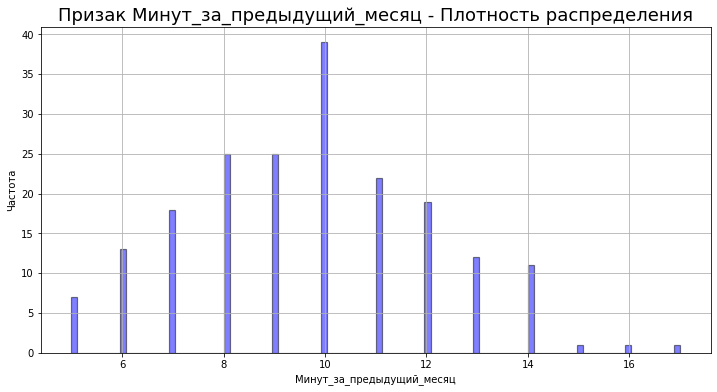

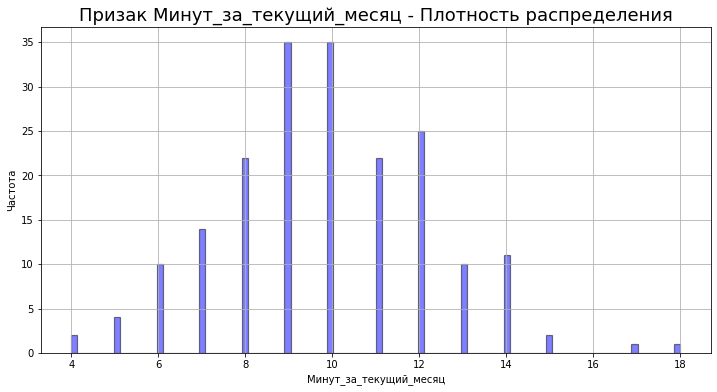

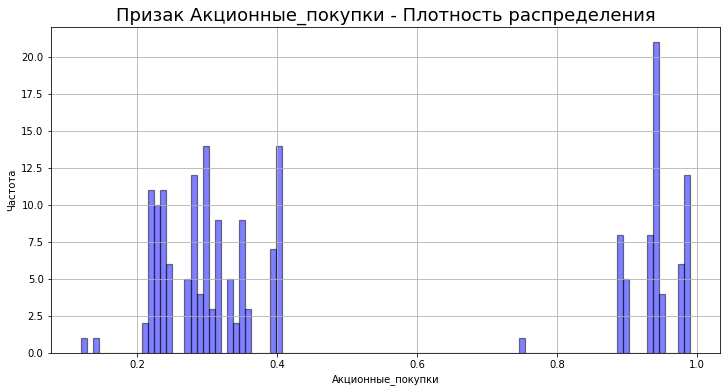

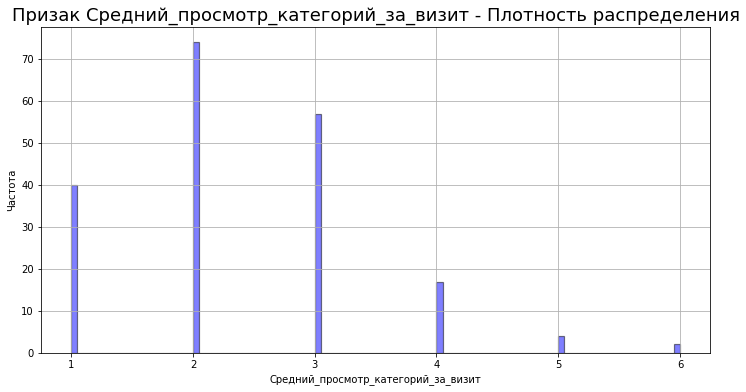

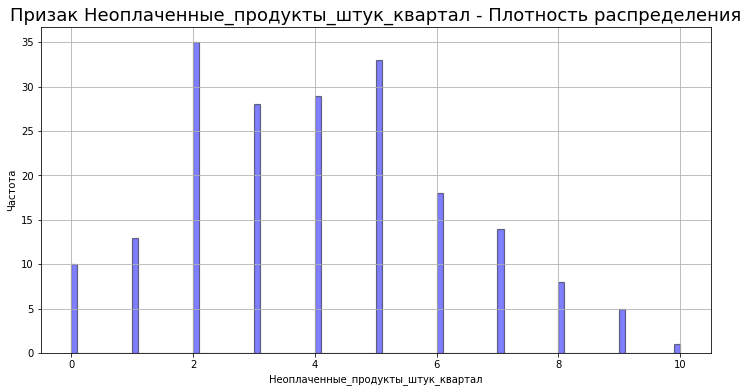

In [93]:
for num in num_research:
    create(df_reserch, num, 'hist')

### Промежуточный вывод по сегментации покупателей

**В качестве целевой аудитории, на которых можно было бы улучшать покупательскую активность - выбрали покупателей с высокой прибылью(от 0.4) и высокой вероятностью снижения активности(выше 75%)**

**На основе полученных диаграмм можно провести анализ сегментации покупателей и сделать следующие выводы:**
1. Круговая диаграмма "Популярные категории":
    * Самый большой сегмент покупок приходится на товары для детей (31.2%), за ним следуют косметика и аксессуары (24.8%), кухонная посуда и домашний текстиль (по 15.6% каждый). Это говорит о высоком спросе на детские товары и возможности фокусировки маркетинговых усилий в этой категории.
2. Гистограмма "Признак Разрешить сообщать":
    * Большинство покупателей допускают получение сообщений (показатель "да" значительно выше, чем "нет"), что предоставляет возможности для прямого маркетинга и уведомлений о акциях.
3. Гистограммы распределения других признаков ("Страницы за визит", "Минуты за предыдущий месяц", "Акционные покупки" и т.д.):
    * Покупатели демонстрируют различное взаимодействие с сайтом, что можно использовать для персонализации предложений и улучшения пользовательского опыта.
    
**Предложения по работе с сегментами для увеличения покупательской активности:**
* **Сегмент "Товары для детей":** Учитывая высокий интерес к этой категории, можно предложить специальные акции, бонусные программы для повторных покупок, а также рекламные кампании, нацеленные на родителей.
* **Персонализация предложений:** Используя данные о взаимодействии покупателей с сайтом (количество просмотренных страниц, время, проведённое на сайте), можно создавать персонализированные предложения и рекомендации.
* **Коммуникационная стратегия:** Поскольку большинство клиентов открыты для коммуникаций, стоит использовать электронные письма, SMS и push-уведомления для информирования о новинках, специальных предложениях и скидках.
* Анализ "Акционных покупок": Разработка специальных предложений для тех, кто склонен к акционным покупкам, может стимулировать дополнительные продажи.

**Дополнительное исследование сегмента "Товары для детей":**
Этот сегмент был выбран для дополнительного исследования из-за его значительного размера и потенциала для роста, учитывая интерес к этой категории. Также важно анализировать отзывы клиентов в этой категории для улучшения ассортимента и качества обслуживания.

## Шаг 9. Общий вывод
На основе проведенного анализа четырех датасетов и последующей сегментации покупателей можно сделать следующий общий вывод:

**Загрузка данных и предобратка данных**

Данные из всех источников были полными и хорошо подготовленными, без пропусков, но с потенциальными дубликатами, которые были успешно обработаны в ходе предобработки данных. В датасетах были обнаружены и исправлены некоторые опечатки и ошибки, что повысило качество и точность данных для дальнейшего анализа.

**Исследовательский анализ и корелляционный анализ**

Проведенное исследование и корреляционный анализ выявили ключевые показатели, влияющие на покупательскую активность. Сильная корреляция между признаками выручки за разные месяцы подчеркивает стабильность покупательского поведения, а средняя корреляция между временем, проведенным на сайте, и выручкой указывает на потенциал персонализации предложений для увеличения продаж.
Исследовательский анализ данных позволил идентифицировать основные сегменты покупателей и выявить поведенческие паттерны. 
Результаты корреляционного анализа не выявили мультиколлинеарности, что позволяет использовать все признаки в моделях машинного обучения без опасения искажения результатов из-за высокой взаимосвязи между переменными.

**Объединение таблиц**

Объединение таблиц и удаление несущественных пропусков дало возможность создать единую базу для анализа и принятия решений. 

**Пайплайн**

По результатам оценки модели было установлено, что лучшая модель обладает высокой предсказательной способностью как на тренировочных, так и на тестовых данных, что позволяет считать её надежным инструментом для прогнозирования покупательской активности.

Лучшей моделью является SVC с гиперпараметрами:
* C=0.1;
* degree=2;
* gamma=10;
* kernel = 'linear';
* probability = True;
* random_state = 42

**Анализ важности признаков**

Наиболее значимыми признаками являются:
* Страниц_за_визит, 
* Минут_за_предыдущий_месяц
* Акционные_покупки

**Сегментация покупателей**

В качестве целевой аудитории, на которых можно было бы улучшать покупательскую активность - выбрали покупателей с высокой прибылью(от 0.4) и высокой вероятностью снижения активности(выше 75%)

Сегмент товаров для детей оказался наиболее многообещающим из-за своего значительного размера и потенциала роста. Это позволило предложить целенаправленные маркетинговые и коммуникационные стратегии для улучшения покупательской активности, такие как специальные акции и лояльностные программы, особенно акцентируя внимание на потребностях и предпочтениях родителей.